# Dependency

In [1]:
!pip install nptyping==1.0.1
!pip install SciencePlots
!pip install Theano

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 2.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6484 sha256=babb87a049286ae74c83d2c418915b138fa9c183839532052c03c31d2f4e3b60
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 7.6 MB/s 
  Created wheel for Theano: filename=Theano-1.0.5-py3-none-any.whl size=2668111 sha256=49eaccbe242bda1d2db0abe9975efbe448

# Initiate the model

In [2]:

import tensorflow as tf

# gpus = tf.config.experimental.list_physical_devices('GPU') 
# for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
from sys import getsizeof

import matplotlib
# from ipywidgets import interact, interactive
import os
import numpy as np
import sys
import timeit
import csv
from functools import reduce
import operator

sys.path.append('/content/drive/My Drive/YJ/GP_old')

sys.path.append('/content/drive/My Drive/YJ')

sys.path.append('/content/drive/MyDrive/YJ/Gravity_valid')
import matplotlib.pyplot as plt

from gempy.core.grid_modules.grid_types import CenteredGrid

import gempy as gp
from gempy.core.tensor.tensorflow_graph_test import TFGraph
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from gempy import create_data, map_series_to_surfaces
from gempy.assets.geophysics import GravityPreprocessing
tfd = tfp.distributions
import seaborn as sns
import copy
from gempy.plot.visualization_2d_pro import *
from ThreeLayer import *
# %%

X = [5000]
Y = [5000]
# X = np.linspace(2000,8000,5)
# Y = np.linspace(3000,7000,4)

r = []
for x in X:
  for y in Y:
    r.append(np.array([x,y]))
receivers = np.array(r)
Z = 1000
n_devices = receivers.shape[0]

path = '/content/drive/MyDrive/YJ/GP_old/notebooks'
orientation_path = "/data/input_data/George_models/modely_orientations.csv"
surface_path = '/data/input_data/George_models/'+"modely"+'_surface_points.csv'

center_grid_resolution = [21,21,10]
# center_grid_resolution = [51,51,30]
regular_grid_resolution =[100, 100, 30]
radius=[3000,3000,1000]

model = ModelThree(path,surface_path,orientation_path,receivers = receivers,center_grid_resolution = center_grid_resolution,regular_grid_resolution =regular_grid_resolution,dtype = 'float64',radius = radius)
# model.plot_model()
# plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2302: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  max_coord = df.max()[['X', 'Y', 'Z']]
/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:2303: 

Active grids: ['regular']


/content/drive/My Drive/YJ/GP_old/gempy/core/data.py:1100: FutureWarning: The behavior of DataFrame([categorical, ...]) is deprecated and in a future version will be changed to match the behavior of DataFrame([any_listlike, ...]). To retain the old behavior, pass as a dictionary DataFrame({col: categorical, ..})
  f, columns=['series'])
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/content/drive/My Drive/YJ/GP_old/gempy/core/model.py:920: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  ordered=False, inplace=True)
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter

Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']


#Centered regular grid

In [3]:
class CenteredRegGrid(CenteredGrid):
    """
    linear spaced centered grid.
    """
    @staticmethod
    def create_irregular_grid_kernel(resolution, radius):
        """
        Create an isometric grid kernel (centered at 0)

        Args:
            resolution: [s0]
            radius (float): Maximum distance of the kernel

        Returns:
            tuple: center of the voxel, left edge of each voxel (for xyz), right edge of each voxel (for xyz).
        """

        if not isinstance(radius, list) or isinstance(radius, np.ndarray):
            radius = np.repeat(radius, 3)

        g_ = []
        g_2 = [] # contains exp coord, left right xy, top and bottom
        d_ = []
        # size of each grid
        res_ =copy.deepcopy(resolution)
        if res_[0]%2 == 0:
          res_[0]+=1
        if res_[1]%2 == 0:
          res_[1]+=1
        dx = radius[0]*2/res_[0]
        dy = radius[1]*2/res_[1]
        dz = radius[2]/res_[2]
        dxyz = [dx,dy,dz]
        for xyz in [0, 1, 2]:
            if xyz == 2: # --> z
                # Make the grid only negative for the z axis
                g_.append(np.linspace(0, 1, int(resolution[xyz]),endpoint=False))
                g_2.append(
                    ((g_[xyz]+0.005)* - radius[xyz] - dz/2))
                
                d_.append(np.diff(np.pad(g_2[xyz], 1, 'reflect', reflect_type='odd')))
            else:
                g_.append(np.linspace(0, 1, num = resolution[xyz] // 2+1,endpoint=True))
                g_2.append(
                    np.concatenate((-g_[xyz][::-1], g_[xyz][1:])) * (radius[xyz]-dxyz[xyz]/2))
                d_.append(np.diff(np.pad(g_2[xyz], 1, 'reflect', reflect_type='odd')))
        
        g = np.meshgrid(*g_2)
        d_left = np.meshgrid(d_[0][:-1] / 2, d_[1][:-1] / 2, d_[2][:-1]/2)
        d_right = np.meshgrid(d_[0][1:] / 2, d_[1][1:] / 2, d_[2][1:]/2)
        kernel_g = np.vstack(tuple(map(np.ravel, g))).T.astype("float64")
        kernel_d_left = np.vstack(tuple(map(np.ravel, d_left))).T.astype("float64")
        kernel_d_right = np.vstack(tuple(map(np.ravel, d_right))).T.astype("float64")

        return kernel_g, kernel_d_left, kernel_d_right


In [4]:
res = center_grid_resolution
centerReg = CenteredRegGrid(model.xy_ravel,radius=radius,resolution=res)
size = reduce((lambda x, y: x * y), res)

(4410, 3)
<tf.Variable 'Variable:0' shape=(11,) dtype=float32, numpy=
array([-1.2403723 , -0.06536541,  0.41015726,  0.7887358 ,  1.1164645 ,
        1.4143891 ,  1.7306225 ,  2.0853188 ,  2.5096593 ,  3.082     ,
        3.9924538 ], dtype=float32)>


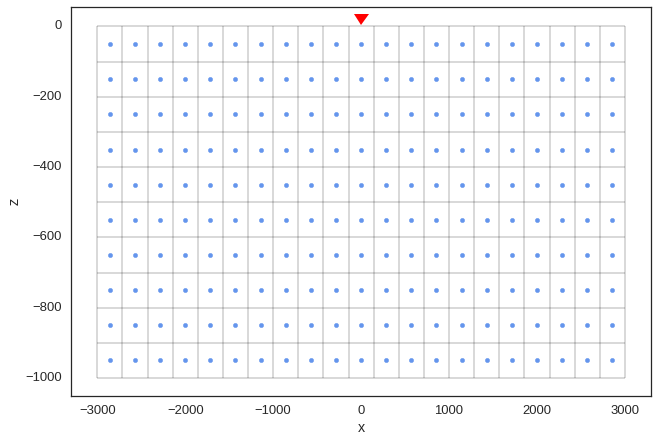

In [32]:
def plot_centered_kernel(res,radius,centerkernel,direction = 'y',n_section = 5,ax = None):
  if ax is None:
    fig,ax = plt.subplots(1,1)
  res_ =copy.deepcopy(res)
  if direction == 'y': i = 0 
  else: i = 1
  
  if isinstance(centerkernel,CenteredRegGrid):
    kernel_g, kernel_d_left, kernel_d_right = centerkernel.create_irregular_grid_kernel(resolution = res,radius=radius)
    print(kernel_g.shape)
    Slice = n_section
    # Trick just for plotting
    # the resolution is transposed in meshgrid
    if res_[0]%2 == 0:
      res_[0]+=1
    if res_[1]%2 == 0:
      res_[1]+=1
    res_[0],res_[1] =res_[1], res_[0]
    # plotting the centers
    if i == 0: # y direction        
      ax.scatter(kernel_g[:,i].reshape(res_)[Slice,:,:],kernel_g[:,2].reshape(res_)[Slice,:,:],c = 'b') # center
      ax.scatter((kernel_g[:,i]-kernel_d_left[:,i]).reshape(res_)[Slice,:,:],kernel_g[:,2].reshape(res_)[Slice,:,:],'r')
    if i == 1: # x direction
      ax.scatter(kernel_g[:,i].reshape(res_)[:,Slice,:],kernel_g[:,2].reshape(res_)[:,Slice,:],s  =19,c = 'cornflowerblue') # center
      left_x = (kernel_g[:,i]-kernel_d_left[:,i]).reshape(res_)[:,Slice,:].flatten()
      right_x = (kernel_g[:,i]+kernel_d_right[:,i]).reshape(res_)[:,Slice,:].flatten()
      top_z = (kernel_g[:,2]-kernel_d_left[:,2]).reshape(res_)[:,Slice,:].flatten()
      bot_z = (kernel_g[:,2]+kernel_d_left[:,2]).reshape(res_)[:,Slice,:].flatten()

      ax.vlines(x = left_x[::res[-1]],ymax = np.min(bot_z),ymin = np.max(top_z),linewidth=0.3,alpha=1,colors='black')
      ax.vlines(x = right_x[-1],ymax = np.min(bot_z),ymin = np.max(top_z),linewidth=0.3,alpha=1,colors='black')

      ax.hlines(y = bot_z[:res[-1]],xmax = np.min(left_x),xmin = np.max(right_x),linewidth=0.3,alpha=1,colors='black')
      ax.hlines(y = top_z[0],xmax = np.min(left_x),xmin = np.max(right_x),linewidth=0.3,alpha=1,colors='black')
      ax.plot(0,0,marker = 7,c='r',markersize = 15,label = 'Receiver')
      ax.set_xlabel('x')
      ax.set_ylabel('z')

      # a= ax.get_yticks().tolist()
      # ax.set_yticklabels([int(abs(tick)) for tick in a], minor=False)

      print(a)

plot_centered_kernel(res,radius,centerReg,'x',n_section = 2)

In [6]:
# activate the customized grid
def activate_customized_grid(model,centerReg):
  model.geo_data.grid.custom_grid=centerReg
  model.geo_data.grid.deactivate_all_grids()
  # activate also rescaled the grid
  model.geo_data.grid.set_active('custom')
  model.geo_data.rescaling.set_rescaled_grid()


In [7]:
def calculate_grav_center_regular(model,centerReg,values_properties):
  activate_customized_grid(model,centerReg)
  g_center_regulargrid = GravityPreprocessing(centerReg)
  tz_center_regulargrid = g_center_regulargrid.set_tz_kernel()
  fault_drift = np.zeros((0, model.grid.values.shape[0] ))
  size = centerReg.values.shape[0]
  fault_drift = fault_drift[:,:size]
  grid_tensor = model.geo_data.grid.values_r
  model.TFG = TFGraph(model.dip_angles, model.azimuth,model.polarity, fault_drift,
  grid_tensor, model.values_properties, model.len_rest_form, model.Range,
  model.C_o, model.nugget_effect_scalar, model.nugget_effect_grad,
  model.rescale_factor,dtype = model.tfdtype)
  Z_x = model.TFG.scalar_field(model.surface_points_coord,model.dips_position)

  scalar_field_at_surface_points = model.TFG.get_scalar_field_at_surface_points(Z_x)
  # formations_block = model.TFG.export_formation_block(
  #     Z_x, scalar_field_at_surface_points, model.values_properties)
  formations_block = model.TFG.export_formation_block(
      Z_x, scalar_field_at_surface_points, values_properties)

  # densities = formations_block[1][model.lg_0:model.lg_1]
  densities = formations_block[1][:size]

  gravity_center_reg = model.TFG.compute_forward_gravity(tz_center_regulargrid, 0, size, densities)
  return gravity_center_reg

In [8]:
model.activate_regular_grid()

In [9]:
gravity_center_reg = calculate_grav_center_regular(model,centerReg,model.values_properties)

## Resolution

In [10]:
# gravity_center_reg_list = []
# for i in range(5,30,2):
#   print(i)
#   res = [i,40,i]
#   centerReg = CenteredRegGrid(model.xy_ravel,radius=[2000,2000,1000],resolution=res)
#   print(centerReg.kernel_centers.shape)
#   gravity_center_reg = calculate_grav_center_regular(model.values_properties)
#   gravity_center_reg_list.append(gravity_center_reg)
#   # plot_centered_kernel(res,1000,centerReg,'x',n_section = 2)

In [11]:
# plt.plot(gravity_center_reg_list)

# Centered grid

In [12]:
center_grid_resolution = res
# path = '/content/drive/MyDrive/YJ/GP_old/notebooks'
# model = ModelThree(path,surface_path,orientation_path,receivers = receivers,center_grid_resolution = center_grid_resolution,regular_grid_resolution =regular_grid_resolution,dtype = 'float64')

model.activate_centered_grid()
grav_centered = model.calculate_grav(model.surface_points_coord,model.values_properties)

(4410, 3)


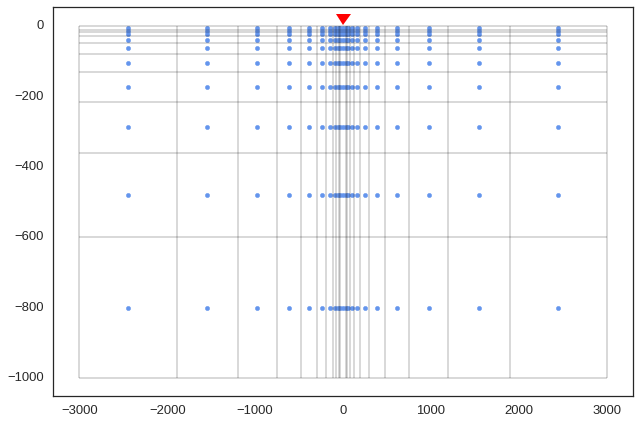

In [33]:
def plot_centered_kernel(res,radius,centerkernel,direction = 'y',n_section = 5,ax = None):
  if ax is None: 
    fig,ax = plt.subplots(1,1)
  res_ =copy.deepcopy(res)
  if direction == 'y': i = 0 
  else: i = 1
  
  if isinstance(centerkernel,CenteredGrid):
    kernel_g, kernel_d_left, kernel_d_right = centerkernel.create_irregular_grid_kernel(resolution = res,radius=radius)
    print(kernel_g.shape)
    Slice = n_section
    # Trick just for plotting
    # the resolution is transposed in meshgrid
    if res_[0]%2 == 0:
      res_[0]+=1
    if res_[1]%2 == 0:
      res_[1]+=1
    # res_[2]+=1
    res_[0],res_[1] =res_[1], res_[0]
    # plotting the centers
    if i == 0: # y direction        
      ax.scatter(kernel_g[:,i].reshape(res_)[Slice,:,:],kernel_g[:,2].reshape(res_)[Slice,:,:],c = 'b') # center
      ax.scatter((kernel_g[:,i]-kernel_d_left[:,i]).reshape(res_)[Slice,:,:],kernel_g[:,2].reshape(res_)[Slice,:,:],'r')
    if i == 1: # x direction
      ax.scatter(kernel_g[:,i].reshape(res_)[:,Slice,:],kernel_g[:,2].reshape(res_)[:,Slice,:],s  =19,c = 'cornflowerblue') # center
      left_x = (kernel_g[:,i]-kernel_d_left[:,i]).reshape(res_)[:,Slice,:].flatten()
      right_x = (kernel_g[:,i]+kernel_d_right[:,i]).reshape(res_)[:,Slice,:].flatten()
      top_z = (kernel_g[:,2]-kernel_d_left[:,2]).reshape(res_)[:,Slice,:].flatten()
      bot_z = (kernel_g[:,2]+kernel_d_left[:,2]).reshape(res_)[:,Slice,:].flatten()

      # ax.scatter(left_x,kernel_g[:,2].reshape(res_)[:,Slice,:].flatten(),s  =13, c = 'g',alpha=0.5) # left
      # ax.scatter(right_x,kernel_g[:,2].reshape(res_)[:,Slice,:].flatten(),s = 13, c = 'r',alpha=0.5) # right
      # ax.scatter(kernel_g[:,i].reshape(res_)[:,Slice,:],top_z,s = 13, c = 'k',alpha=0.5) # top
      # ax.scatter(kernel_g[:,i].reshape(res_)[:,Slice,:],bot_z,s = 13, c = 'y',alpha=0.5) # bot

    ax.vlines(x = left_x[::res[-1]],ymax = np.min(bot_z),ymin = np.max(top_z),linewidth=0.3,alpha=1,colors='black')
    ax.vlines(x = right_x[-1],ymax = np.min(bot_z),ymin = np.max(top_z),linewidth=0.3,alpha=1,colors='black')

    ax.hlines(y = bot_z[:res[-1]],xmax = np.min(left_x),xmin = np.max(right_x),linewidth=0.3,alpha=1,colors='black')
    ax.hlines(y = top_z[0],xmax = np.min(left_x),xmin = np.max(right_x),linewidth=0.3,alpha=1,colors='black')
    ax.plot(0,0,marker = 7,c='r',markersize = 15,label = 'Receiver')

    # set axis to depth
    # a= ax.get_yticks().tolist()
    # ax.set_yticklabels([int(abs(tick)) for tick in a], minor=False)
    
plot_centered_kernel(center_grid_resolution,radius,model.grid.centered_grid,direction='x',n_section = 2)

# ML

In [14]:
def make_variables(k, initializer):
  return (tf.Variable(initializer(shape=[k], dtype=tf.float32)))

def softmax_space(parameters):
  return tf.nn.softmax(parameters)

def constant32(x):
  return tf.constant(x,dtype=tf.float32)

In [15]:
resolution = constant32(center_grid_resolution)
radius_t =constant32(radius)
size = (resolution[0]+1)*(resolution[1]+1)*(resolution[2])


In [16]:

def compute_tz(a,b,c):
  g_x = tf.cumsum(softmax_space(a))
  g_y = tf.cumsum(softmax_space(b))
  g_z = tf.cumsum(softmax_space(c))

  g2_x = tf.concat((-g_x[::-1], g_x),axis=0) * radius_t[0]
  g2_y = tf.concat((-g_y[::-1], g_y),axis=0) * radius_t[1]
  g2_z =  (tf.concat(([0], g_z),axis=0) + 0.005) * - radius_t[2]

  x_center = (g2_x[:-1]+g2_x[1:])/2 
  y_center = (g2_y[:-1]+g2_y[1:])/2
  z_center = (g2_z[:-1]+g2_z[1:])/2

  g = tf.meshgrid(x_center,y_center,z_center)

  d_left_x = tf.math.abs(g2_x[:-1] - x_center)
  d_left_y = tf.math.abs(g2_y[:-1] - y_center)
  d_right_x = tf.math.abs(g2_x[1:] - x_center)
  d_right_y = tf.math.abs(g2_y[1:] - y_center)
  d_z = z_center - g2_z[:-1]

  d_left = tf.meshgrid(d_left_x,d_left_y,d_z)
  d_right = tf.meshgrid(d_right_x,d_right_y,d_z)

  kernel_g = tf.concat([tf.reshape(g[0],[-1,1]),tf.reshape(g[1],[-1,1]),tf.reshape(g[2],[-1,1])],axis=1)
  kernel_d_left = tf.concat([tf.reshape(d_left[0],[-1,1]),tf.reshape(d_left[1],[-1,1]),tf.reshape(d_left[2],[-1,1])],axis=1)
  kernel_d_right = tf.concat([tf.reshape(d_right[0],[-1,1]),tf.reshape(d_right[1],[-1,1]),tf.reshape(d_right[2],[-1,1])],axis=1)

  s_gr_x = kernel_g[:, 0]
  s_gr_y = kernel_g[:, 1]
  s_gr_z = kernel_g[:, 2]

  # # getting the coordinates of the corners of the voxel...
  x_cor = tf.transpose(tf.stack([s_gr_x - kernel_d_left[:, 0], s_gr_x + kernel_d_right[:, 0]], axis=0))
  y_cor = tf.transpose(tf.stack((s_gr_y - kernel_d_left[:, 1], s_gr_y + kernel_d_right[:, 1]), axis=0))
  z_cor = tf.transpose(tf.stack((s_gr_z - kernel_d_left[:, 2], s_gr_z + kernel_d_right[:, 2]), axis=0))

  x_matrix = tf.repeat(x_cor, 4, axis=1)
  y_matrix = tf.tile(tf.repeat(y_cor, 2, axis=1), (1, 2))
  z_matrix = tf.tile(z_cor, (1, 4))

  s_r = tf.sqrt(x_matrix ** 2 + y_matrix ** 2 + z_matrix ** 2)

  mu = constant32([1, -1, -1, 1, -1, 1, 1, -1])

  G = constant32(6.674e-3)

  tz = (
        G *
        tf.reduce_sum(- 1 *
                mu * (
                        x_matrix * tf.math.log(y_matrix + s_r) +
                        y_matrix * tf.math.log(x_matrix + s_r) -
                        z_matrix * tf.math.atan(x_matrix * y_matrix / (z_matrix * s_r))),
                axis=1))
  return tz



def loss(a,b,c):
  tz = compute_tz(a,b,c)
  l = tf.math.reduce_std(tz)
  return l



In [17]:
min = -1
max = 1
a = make_variables(tf.cast(resolution[0]/2+1,tf.int32),initializer= tf.random_uniform_initializer(minval=min, maxval=max, seed=None))
b = make_variables(tf.cast(resolution[1]/2+1,tf.int32),initializer= tf.random_uniform_initializer(minval=min, maxval=max, seed=None))
c = make_variables(tf.cast(resolution[2],tf.int32),initializer= tf.random_uniform_initializer(minval=min, maxval=max, seed=None))

var_list =[a,b,c]

@tf.function
def train_step(a,b,c):
  with tf.GradientTape() as tape:
    loss_value = loss(a,b,c)
    grads = tape.gradient(loss_value,var_list)

  opt.apply_gradients(zip(grads, var_list))
  return loss_value

In [18]:
# opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
opt = tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

import time
epochs = 1000
for epoch in range(epochs):
  
  
  start_time = time.time()
  loss_value = train_step(a,b,c)
  if epoch%200==0:
    print("\nStart of epoch %d" % (epoch,))
    print("loss: %.4f" % (float(loss_value),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
loss: 0.1185
Time taken: 2.78s

Start of epoch 200
loss: 0.0207
Time taken: 0.01s

Start of epoch 400
loss: 0.0105
Time taken: 0.00s

Start of epoch 600
loss: 0.0087
Time taken: 0.00s

Start of epoch 800
loss: 0.0084
Time taken: 0.00s


In [19]:
a,b,c = var_list

In [20]:
g_x = softmax_space(a)
tf.cumsum(g_x)

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([0.00253566, 0.01074654, 0.02395665, 0.04324616, 0.07001638,
       0.10607748, 0.15555152, 0.22608902, 0.33391136, 0.52501684,
       1.        ], dtype=float32)>

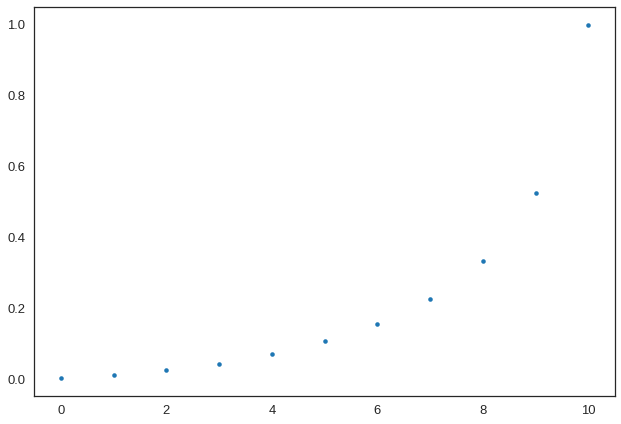

In [21]:
# plt.plot(a.numpy(),'.')
# plt.plot(softmax_space(a).numpy(),'.')
plt.plot(tf.cumsum(softmax_space(a)).numpy(),'.')

In [22]:
def create_irregular_grid_kernel(resolution, radius,a,b,c):

    g_x = tf.cumsum(softmax_space(a))
    g_y = tf.cumsum(softmax_space(b))
    g_z = tf.cumsum(softmax_space(c))

    g2_x = tf.concat((-g_x[::-1], g_x),axis=0) * radius[0]
    g2_y = tf.concat((-g_y[::-1], g_y),axis=0) * radius[1]
    g2_z =  (tf.concat(([0], g_z),axis=0) + 0.005) * - radius[2]

    x_center = (g2_x[:-1]+g2_x[1:])/2 
    y_center = (g2_y[:-1]+g2_y[1:])/2
    z_center = (g2_z[:-1]+g2_z[1:])/2

    g = tf.meshgrid(x_center,y_center,z_center)

    d_left_x = tf.math.abs(g2_x[:-1] - x_center)
    d_left_y = tf.math.abs(g2_y[:-1] - y_center)
    d_right_x = tf.math.abs(g2_x[1:] - x_center)
    d_right_y = tf.math.abs(g2_y[1:] - y_center)
    d_z = z_center - g2_z[:-1]

    d_left = tf.meshgrid(d_left_x,d_left_y,d_z)
    d_right = tf.meshgrid(d_right_x,d_right_y,d_z)

    kernel_g = tf.concat([tf.reshape(g[0],[-1,1]),tf.reshape(g[1],[-1,1]),tf.reshape(g[2],[-1,1])],axis=1)
    kernel_d_left = tf.concat([tf.reshape(d_left[0],[-1,1]),tf.reshape(d_left[1],[-1,1]),tf.reshape(d_left[2],[-1,1])],axis=1)
    kernel_d_right = tf.concat([tf.reshape(d_right[0],[-1,1]),tf.reshape(d_right[1],[-1,1]),tf.reshape(d_right[2],[-1,1])],axis=1)

    return kernel_g, kernel_d_left, kernel_d_right


In [30]:
def plot_ml_kernel(res,radius,a,b,c,direction = 'y',n_section = 5,ax = None,tz=None):
  if ax is None:
    fig,ax = plt.subplots(1,1)
  # res_ =copy.deepcopy(res.numpy()).astype(int)
  res_ =copy.deepcopy(res).astype(int)
  if direction == 'y': i = 0 
  else: i = 1
  
  kernel_g, kernel_d_left, kernel_d_right =create_irregular_grid_kernel(resolution,radius,a,b,c)
  kernel_g, kernel_d_left, kernel_d_right = kernel_g.numpy(), kernel_d_left.numpy(), kernel_d_right.numpy()

  Slice = n_section
  # Trick just for plotting
  # the resolution is transposed in meshgrid
  if res_[0]%2 == 0:
    res_[0]+=1
  if res_[1]%2 == 0:
    res_[1]+=1
  # res_[2]+=1
  res_[0],res_[1] =res_[1], res_[0]
  # plotting the centers
  if i == 0: # y direction    
    center_xy_coord = kernel_g[:,i].reshape(res_)[Slice,:,:]
    center_z_coord = kernel_g[:,2].reshape(res_)[Slice,:,:]
    if tz is not None:
      tz_ = tz.reshape(res_)[Slice,:,:]
    # plt.scatter(kernel_g[:,i].reshape(res_)[Slice,:,:],kernel_g[:,2].reshape(res_)[Slice,:,:],c = 'b') # center
    # plt.scatter((kernel_g[:,i]-kernel_d_left[:,i]).reshape(res_)[Slice,:,:],kernel_g[:,2].reshape(res_)[Slice,:,:],'r')
    ax.set_xlabel('x')
  if i == 1: # x direction
    center_xy_coord = kernel_g[:,i].reshape(res_)[:,Slice,:]
    center_z_coord = kernel_g[:,2].reshape(res_)[:,Slice,:]
    if tz is not None:
      tz_ = tz.reshape(res_)[:,Slice,:]

  if tz is not None:
    ax.scatter(center_xy_coord,center_z_coord,s  =tz_,c = 'cornflowerblue') # center
    print(tz.max(),tz.min())
  else:
    ax.scatter(center_xy_coord,center_z_coord,s  =19,c = 'cornflowerblue') # center

  left_x = (kernel_g[:,i]-kernel_d_left[:,i]).reshape(res_)[:,Slice,:].flatten()
  right_x = (kernel_g[:,i]+kernel_d_right[:,i]).reshape(res_)[:,Slice,:].flatten()
  top_z = (kernel_g[:,2]-kernel_d_left[:,2]).reshape(res_)[:,Slice,:].flatten()
  bot_z = (kernel_g[:,2]+kernel_d_left[:,2]).reshape(res_)[:,Slice,:].flatten()
  
  ax.vlines(x = left_x[::res_[-1]],ymax = np.min(bot_z),ymin = np.max(top_z),linewidth=0.3,alpha=1,colors='black')
  ax.vlines(x = right_x[-1],ymax = np.min(bot_z),ymin = np.max(top_z),linewidth=0.3,alpha=1,colors='black')

  ax.hlines(y = bot_z[:res_[-1]],xmax = np.min(left_x),xmin = np.max(right_x),linewidth=0.3,alpha=1,colors='black')
  ax.hlines(y = top_z[0],xmax = np.min(left_x),xmin = np.max(right_x),linewidth=0.3,alpha=1,colors='black')
  ax.plot(0,0,marker = 7,c='r',markersize = 15,label = 'Receiver')

  # revert ticks to allow plotting possitive value downwards in matplotlib
  # a= ax.get_yticks().tolist()
  # ax.set_yticklabels([int(abs(tick)) for tick in a], minor=False)
# plot_kernel(resolution,[3000,3000,1000],a,b,c,direction='x',n_section = 25)

In [24]:
tz = compute_tz(a,b,c).numpy()

In [25]:
# plot_kernel(resolution,[3000,3000,1000],a,b,c,direction='x',n_section = 26,tz=-tz*10000)

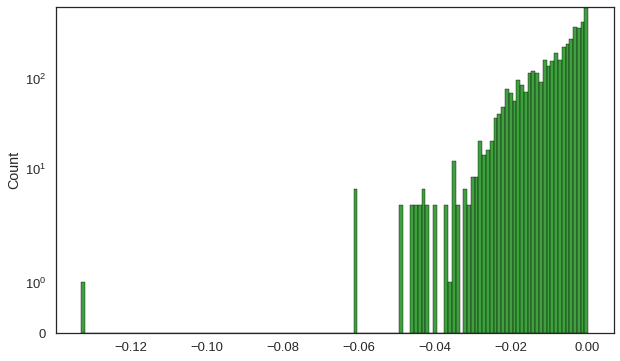

In [26]:
import math
w = 0.001
n_center_regulargrid = math.ceil((tz.max() - tz.min())/w)
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=tz,color='green',bins = n_center_regulargrid)
ax.set_yscale('symlog')

In [27]:
print('machine learning grid', 'std:',np.std(tz),'mean',np.mean(tz),'sum',np.sum(tz))

machine learning grid std: 0.008293749 mean -0.008099896 sum -35.720543


# Plotting

In [28]:
# model.activate_centered_grid()

(4410, 3)
(4410, 3)


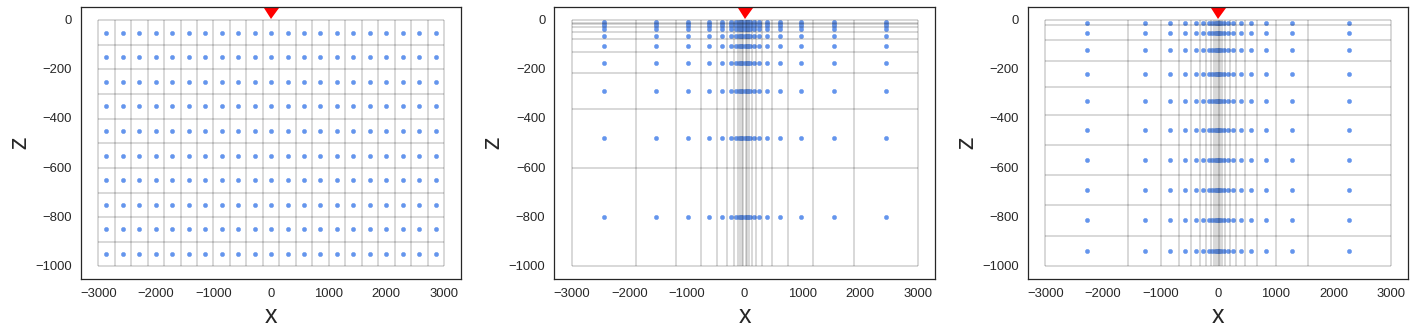

In [34]:
fig,axes = plt.subplots(1,3,figsize = (20,5))
plot_centered_kernel(res,radius,centerReg,'x',n_section = 2,ax = axes[0])
plot_centered_kernel(center_grid_resolution,radius,model.grid.centered_grid,direction='x',n_section = 2,ax = axes[1])
plot_ml_kernel(np.array(center_grid_resolution),radius,a,b,c,direction='x',n_section = 2,ax = axes[2])
for ax in axes:
  ax.set_xlabel('x',fontsize = 25)
  ax.set_ylabel('z',fontsize = 25)
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/YJ/Gravity_valid/Figures/tz_plot_202010_R1_elevation.png',dpi = 300)

In [ ]:
g_center_regulargrid = GravityPreprocessing(centerReg)
tz_center_regulargrid = g_center_regulargrid.set_tz_kernel()

In [ ]:
g_center_geom = GravityPreprocessing(model.grid.centered_grid)
tz_center_geom = g_center_geom.set_tz_kernel()

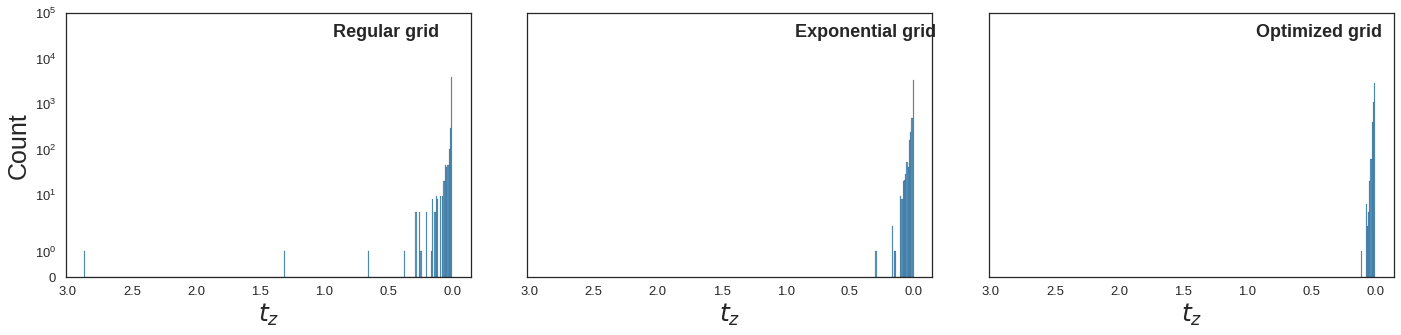

In [ ]:
fig,axes = plt.subplots(1,3,figsize = (20,5),sharex=True,sharey=True)

w = 0.01
n_center_regulargrid = math.ceil((tz_center_regulargrid.max() - tz_center_regulargrid.min())/w)
sns.histplot(data=tz_center_regulargrid,bins = n_center_regulargrid,ax = axes[0])
# sns.kdeplot(data = tz_center_regulargrid,ax = axes [0],color = 'red')

n_centered_exp = math.ceil((tz_center_geom.max() - tz_center_geom.min())/w)
sns.histplot(data=tz_center_geom,bins =n_centered_exp,ax = axes[1])
# sns.kdeplot(data = tz_centered,ax = axes [1],color = 'red')

n_center_optimized = math.ceil((tz.max() - tz.min())/w)
sns.histplot(data=tz,bins = n_center_optimized,ax = axes[2])
# sns.kdeplot(data = tz,ax = axes [2],color = 'red')

for ax in axes:
  ax.set_ylim(top = 1e5) 
  ax.set_yscale('symlog')
  ax.set_ylabel('Count',fontsize = 25)
  ax.set_xlabel('$t_z$',fontsize = 25)

  a= ax.get_xticks().tolist()
  ax.set_xticklabels(["{0:.1f}".format(abs(tick)) for tick in a], minor=False)
# "{:.2f}".format(z)
# text_x = -2.8
# text_y = 3000
text_x = -.93
text_y = 30000
axes[0].text(text_x,text_y,'Regular grid',weight='bold')
axes[1].text(text_x,text_y,'Exponential grid',weight='bold')
axes[2].text(text_x,text_y,'Optimized grid',weight='bold')
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/YJ/Gravity_valid/Figures/tz_hist_202010_R1.png',dpi = 300)